# AirQo African Air Quality Prediction
In this project, the objective is to estimate PM2.5 levels from satellite observations
based on Aerosol Optical Depth (AOD) for eight cities in seven African countries -
Lagos, Accra, Nairobi, Yaounde, Bujumbura, Kisumu, Kampala, and Gulu - with
varying ground monitoring resolutions, using appropriate machine learning algorithms.
Ground-based observations in the selected cities will be used to validate the satellite
estimates.
### About the dataset
The dataset is given as a project from UnvelCity and the number of rows are 8071 with 80 columns. There are many factors that may determined the air quality and they are given as the feature on the dataset. The target variable is pm2_5.

### Evaluation
The evaluation metric for this competition is Root Mean Squared Error.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error, root_mean_squared_error

import xgboost as xgb

# Data Inspection

In [2]:
# Loading dataset

data = pd.read_csv('Dataset.csv')

In [3]:
# Inspecting the first 10 rows

data.head()

id                   site_id  site_latitude  site_longitude  \
0  id_vjcx08sz91  6531a46a89b3300013914a36        6.53257         3.39936   
1  id_bkg215syli  6531a46a89b3300013914a36        6.53257         3.39936   
2  id_oui2pot3qd  6531a46a89b3300013914a36        6.53257         3.39936   
3  id_9aandqzy4n  6531a46a89b3300013914a36        6.53257         3.39936   
4  id_ali5x2m4iw  6531a46a89b3300013914a36        6.53257         3.39936   

    city  country        date  hour  sulphurdioxide_so2_column_number_density  \
0  Lagos  Nigeria  2023-10-25    13                                       NaN   
1  Lagos  Nigeria  2023-11-02    12                                       NaN   
2  Lagos  Nigeria  2023-11-03    13                                       NaN   
3  Lagos  Nigeria  2023-11-08    14                                       NaN   
4  Lagos  Nigeria  2023-11-09    13                                  0.000267   

   sulphurdioxide_so2_column_number_density_amf  ...  cloud_cloud_top_height  \
0                                           NaN  ...                     NaN   
1                                           NaN  ...                     NaN   
2                                           NaN  ...             6791.682888   
3                                           NaN  ...                     NaN   
4                                      0.774656  ...             1451.050659   

   cloud_cloud_base_pressure  cloud_cloud_base_height  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2               51171.802486              5791.682829   
3                        NaN                      NaN   
4               96215.906250               451.050598   

   cloud_cloud_optical_depth  cloud_surface_albedo  \
0                        NaN                   NaN   
1                        NaN                   NaN   
2                  11.816715              0.192757   
3                        NaN                   NaN   
4                  10.521009              0.153114   

   cloud_sensor_azimuth_angle  cloud_sensor_zenith_angle  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                  -96.411890                  61.045123   
3                         NaN                        NaN   
4                  -97.811241                  49.513439   

   cloud_solar_azimuth_angle  cloud_solar_zenith_angle      pm2_5  
0                        NaN                       NaN  12.015000  
1                        NaN                       NaN  42.267200  
2                -121.307414                 41.898269  39.450741  
3                        NaN                       NaN  10.537600  
4                -126.064453                 40.167355  19.431731  

[5 rows x 80 columns]

In [4]:
# Inspecting the last 10 rows

data.tail()

id                   site_id  site_latitude  site_longitude  \
8066  id_ov6ddbfdf0  647f3a5d69df500029a2fc93      -1.268877       36.819139   
8067  id_3tv6i1a09t  647f3a5d69df500029a2fc93      -1.268877       36.819139   
8068  id_csqjqt3f9i  647f3a5d69df500029a2fc93      -1.268877       36.819139   
8069  id_tv6dzkz7ii  647f3a5d69df500029a2fc93      -1.268877       36.819139   
8070  id_qgxtderh4p  647f3a5d69df500029a2fc93      -1.268877       36.819139   

         city country        date  hour  \
8066  Nairobi   Kenya  2024-01-17    10   
8067  Nairobi   Kenya  2024-01-24    11   
8068  Nairobi   Kenya  2024-01-25    11   
8069  Nairobi   Kenya  2024-01-26    10   
8070  Nairobi   Kenya  2024-01-27    10   

      sulphurdioxide_so2_column_number_density  \
8066                                       NaN   
8067                                 -0.000563   
8068                                       NaN   
8069                                 -0.000188   
8070                                  0.000089   

      sulphurdioxide_so2_column_number_density_amf  ...  \
8066                                           NaN  ...   
8067                                      0.595788  ...   
8068                                           NaN  ...   
8069                                      0.746123  ...   
8070                                      0.752415  ...   

      cloud_cloud_top_height  cloud_cloud_base_pressure  \
8066                     NaN                        NaN   
8067                     NaN                        NaN   
8068                     NaN                        NaN   
8069                     NaN                        NaN   
8070             3458.536865               76573.898438   

      cloud_cloud_base_height  cloud_cloud_optical_depth  \
8066                      NaN                        NaN   
8067                      NaN                        NaN   
8068                      NaN                        NaN   
8069                      NaN                        NaN   
8070              2458.536865                   4.868147   

      cloud_surface_albedo  cloud_sensor_azimuth_angle  \
8066                   NaN                         NaN   
8067                   NaN                         NaN   
8068                   NaN                         NaN   
8069                   NaN                         NaN   
8070               0.18731                   73.323975   

      cloud_sensor_zenith_angle  cloud_solar_azimuth_angle  \
8066                        NaN                        NaN   
8067                        NaN                        NaN   
8068                        NaN                        NaN   
8069                        NaN                        NaN   
8070                  48.218334                 -144.96904   

      cloud_solar_zenith_angle      pm2_5  
8066                       NaN  21.086071  
8067                       NaN  17.110000  
8068                       NaN  15.080000  
8069                       NaN  18.026750  
8070                 21.264854  13.103000  

[5 rows x 80 columns]

#### Creatind a copy of data

In [5]:
# Creating a copy of the data
pd.set_option('display.max_columns', None)

air = data.copy()
air.sample(5) 

id                   site_id  site_latitude  site_longitude  \
4205  id_7a3mr9815v  620dd7ce72eb9200299fb8c1       0.292820       32.571320   
6871  id_38rb8y0t59  60d058c8048305120d2d6172       0.360209       32.610756   
1881  id_736bdzdeh7  624d2f9a994194001ddccbb6       0.288630       32.602970   
2938  id_t720xxu9m7  60d058c8048305120d2d6149       0.347014       32.649360   
902   id_qwnnitlrq9  6353b53377ee57002903db54       0.306112       32.565726   

         city country        date  hour  \
4205  Kampala  Uganda  2023-03-05    11   
6871  Kampala  Uganda  2023-01-31    11   
1881  Kampala  Uganda  2023-07-18    10   
2938  Kampala  Uganda  2023-12-15    10   
902   Kampala  Uganda  2023-01-26    11   

      sulphurdioxide_so2_column_number_density  \
4205                                 -0.000145   
6871                                       NaN   
1881                                 -0.000163   
2938                                       NaN   
902                                        NaN   

      sulphurdioxide_so2_column_number_density_amf  \
4205                                      0.567937   
6871                                           NaN   
1881                                      0.759202   
2938                                           NaN   
902                                            NaN   

      sulphurdioxide_so2_slant_column_number_density  \
4205                                       -0.000082   
6871                                             NaN   
1881                                       -0.000124   
2938                                             NaN   
902                                              NaN   

      sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
4205                            0.0                          -101.712263   
6871                            NaN                                  NaN   
1881                            0.0                            73.706163   
2938                            NaN                                  NaN   
902                             NaN                                  NaN   

      sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
4205                           14.270218                         -106.629985   
6871                                 NaN                                 NaN   
1881                           42.930685                          -34.960405   
2938                                 NaN                                 NaN   
902                                  NaN                                 NaN   

      sulphurdioxide_solar_zenith_angle  \
4205                          22.614660   
6871                                NaN   
1881                          25.607794   
2938                                NaN   
902                                 NaN   

      sulphurdioxide_so2_column_number_density_15km  month  \
4205                                      -0.000043    3.0   
6871                                            NaN    1.0   
1881                                      -0.000054    7.0   
2938                                            NaN   12.0   
902                                             NaN    1.0   

      carbonmonoxide_co_column_number_density  \
4205                                      NaN   
6871                                      NaN   
1881                                 0.027316   
2938                                      NaN   
902                                       NaN   

      carbonmonoxide_h2o_column_number_density  carbonmonoxide_cloud_height  \
4205                                       NaN                          NaN   
6871                                       NaN                          NaN   
1881                               1574.958618                   1067.22583   
2938                                       NaN                          NaN   
902                                        NaN        

In [6]:
# Inspecting the data for informations
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 80 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

This shown that there are  huge numbers of missing values in many of the columns.


#### Statistical Analysis

In [7]:
air.describe()

site_latitude  site_longitude         hour  \
count    8071.000000     8071.000000  8071.000000   
mean        0.635678       30.246982    10.877463   
std         2.154605        9.393151     0.815875   
min        -3.459970        3.201510    10.000000   
25%         0.288630       32.568643    10.000000   
50%         0.332610       32.600480    11.000000   
75%         0.374653       32.641110    11.000000   
max         6.595400       36.914272    14.000000   

       sulphurdioxide_so2_column_number_density  \
count                               3159.000000   
mean                                   0.000024   
std                                    0.000354   
min                                   -0.000980   
25%                                   -0.000196   
50%                                    0.000012   
75%                                    0.000221   
max                                    0.002024   

       sulphurdioxide_so2_column_number_density_amf  \
count                                   3159.000000   
mean                                       0.687295   
std                                        0.142544   
min                                        0.299364   
25%                                        0.589849   
50%                                        0.669632   
75%                                        0.766817   
max                                        1.607052   

       sulphurdioxide_so2_slant_column_number_density  \
count                                     3159.000000   
mean                                         0.000013   
std                                          0.000220   
min                                         -0.000696   
25%                                         -0.000137   
50%                                          0.000007   
75%                                          0.000149   
max                                          0.001101   

       sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
count                    3159.000000                          3159.000000   
mean                        0.126581                             2.120939   
std                         0.094129                            85.450554   
min                         0.000000                          -107.710861   
25%                         0.038062                           -98.911720   
50%                         0.123876                            71.653160   
75%                         0.209070                            74.110476   
max                         0.299850                            77.319656   

       sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
count                         3159.000000                         3159.000000   
mean                            38.671939                          -92.912582   
std                             18.964322                           43.240479   
min                              0.177093                         -165.131509   
25%                             22.811537                         -134.823883   
50%                             42.564364                          -95.848477   
75%                             54.238408                          -49.662067   
max                             66.234924                          -22.250822   

       sulphurdioxide_solar_zenith_angle  \
count                        3159.000000   
mean                           27.700157   
std                             6.844252   
min                            11.406621   
25%                            23.178422   
50%                            27.537424   
75%                            32.547634   
max                            45.469086   

       sulphurdioxide_so2_column_number_density_15km        month  \
count                                    3159.000000  8071.000000   
mean                                        0.000004     6.122414   
std                            

This shown that there are some possible outliers in the data 

In [8]:
# Inspecting the shape
air.shape

(8071, 80)

#### Checking for missing values

In [9]:
missing = (air.isnull().mean()*100).values

missing

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.08598687e+01, 6.08598687e+01, 6.08598687e+01, 6.08598687e+01,
       6.08598687e+01, 6.08598687e+01, 6.08598687e+01, 6.08598687e+01,
       6.08598687e+01, 0.00000000e+00, 4.49758394e+01, 4.49758394e+01,
       4.49758394e+01, 4.49758394e+01, 4.49758394e+01, 4.49758394e+01,
       4.49758394e+01, 4.49758394e+01, 6.15413208e+01, 6.15413208e+01,
       6.15413208e+01, 6.15413208e+01, 6.15413208e+01, 6.15413208e+01,
       6.15413208e+01, 6.15413208e+01, 6.15413208e+01, 6.15413208e+01,
       6.15413208e+01, 6.15413208e+01, 4.85070004e+01, 4.85070004e+01,
       4.85070004e+01, 4.85070004e+01, 4.85070004e+01, 4.85070004e+01,
       4.85070004e+01, 4.85070004e+01, 6.19501920e-02, 6.19501920e-02,
       6.19501920e-02, 6.19501920e-02, 6.19501920e-02, 6.19501920e-02,
       1.38768430e+00, 1.38768430e+00, 1.38768430e+00, 1.38768430e+00,
      

This shown that some columns are missing more than 60% of its value. Since all the calumn are key factor that determine the air quality, I decided to remove columns with more than 75% missing values only.

In [10]:
air = air.drop(columns=['uvaerosollayerheight_aerosol_height','uvaerosollayerheight_aerosol_pressure', 
                        'uvaerosollayerheight_aerosol_optical_depth', 'uvaerosollayerheight_sensor_zenith_angle', 
                        'uvaerosollayerheight_sensor_azimuth_angle','uvaerosollayerheight_solar_azimuth_angle', 
                        'uvaerosollayerheight_solar_zenith_angle'], axis=1)

In [11]:
# Checking to verify if the columns are dropped
missing = (air.isnull().mean()*100).values

missing

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 60.85986867, 60.85986867,
       60.85986867, 60.85986867, 60.85986867, 60.85986867, 60.85986867,
       60.85986867, 60.85986867,  0.        , 44.97583943, 44.97583943,
       44.97583943, 44.97583943, 44.97583943, 44.97583943, 44.97583943,
       44.97583943, 61.54132078, 61.54132078, 61.54132078, 61.54132078,
       61.54132078, 61.54132078, 61.54132078, 61.54132078, 61.54132078,
       61.54132078, 61.54132078, 61.54132078, 48.50700037, 48.50700037,
       48.50700037, 48.50700037, 48.50700037, 48.50700037, 48.50700037,
       48.50700037,  0.06195019,  0.06195019,  0.06195019,  0.06195019,
        0.06195019,  0.06195019,  1.3876843 ,  1.3876843 ,  1.3876843 ,
        1.3876843 ,  1.3876843 ,  1.3876843 ,  1.3876843 ,  1.3876843 ,
        1.3876843 , 38.12414818, 38.12414818, 38.12414818, 38.12414818,
       38.12414818, 38.12414818, 38.12414818, 38.12414818, 38.12

In [12]:
# Subsecting column into its datatypes
date = air['date']
cat = air[['site_id', 'city', 'country']]
num = air.drop(columns=['id', 'date', 'site_id', 'city', 'country'], axis=1)

#### Filling the missing values

In [13]:
# Filling the missing values of categorical columns with their most frequent values
def fill_missing_in_cat(air, columns):
    for col in cat:
        most_frequent = air[col].mode()[0]
        air.fillna({col:most_frequent}, inplace= True)
fill_missing_in_cat(air, cat)

In [14]:
# Filling the missing values of numerical columns with their mean
def fill_missing_in_num(air, columns):
    for col in num:
        mean_value = air[col].mean()
        air.fillna({col:mean_value}, inplace= True)
fill_missing_in_num(air, num)

#### Confirming if missing values are gone

In [15]:
missing = (air.isnull().mean()*100).values

missing

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

#### Checking for duplicates

In [16]:
air.duplicated().sum()

np.int64(0)

Zero duplicate was found

#### Converting columns to its datatypes

In [17]:
# converting column data to its data types

for col in air.columns:
    if col in cat:
        air[col] = air[col].astype('category')
    elif col in num:
        air[col] = air[col].astype(float)

air['date'] = pd.to_datetime(air['date'])

In [18]:
air.dtypes

id                              object
site_id                       category
site_latitude                  float64
site_longitude                 float64
city                          category
                                ...   
cloud_sensor_azimuth_angle     float64
cloud_sensor_zenith_angle      float64
cloud_solar_azimuth_angle      float64
cloud_solar_zenith_angle       float64
pm2_5                          float64
Length: 73, dtype: object

#### Checking for outliers

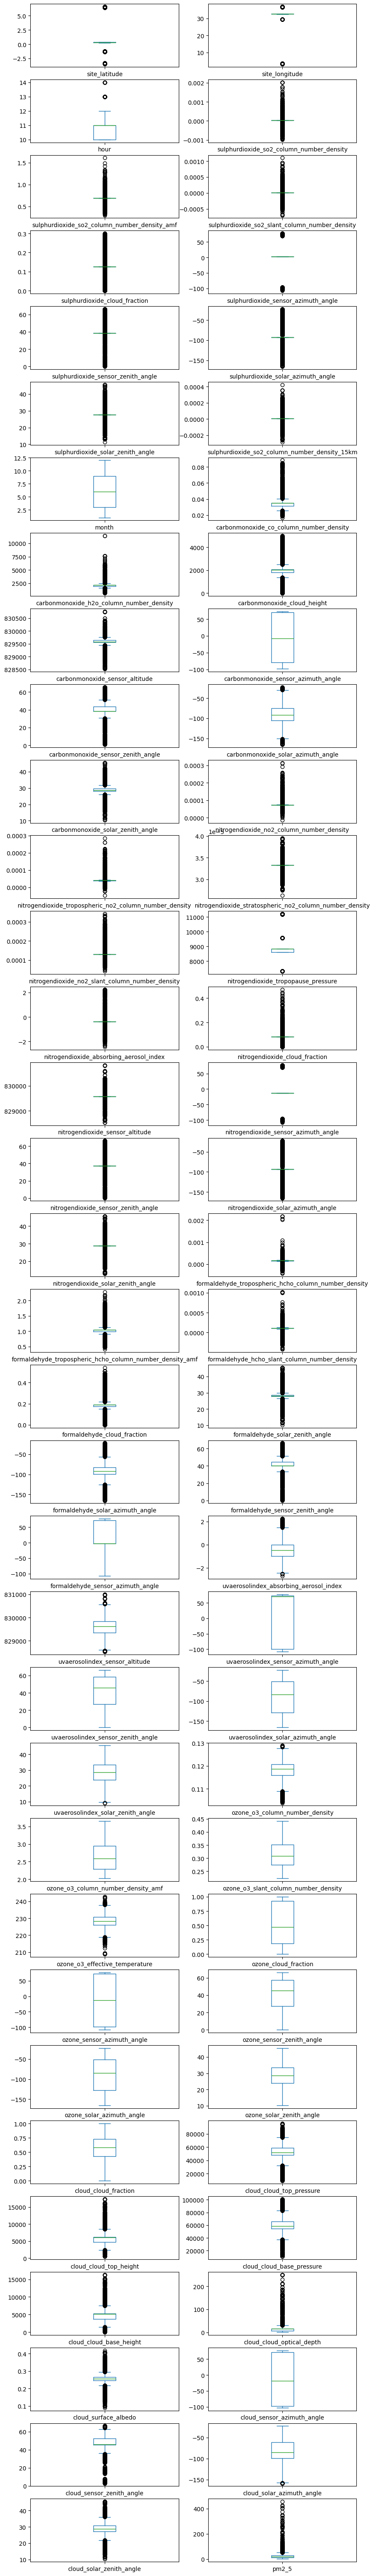

In [19]:
# checking out for outliers using boxplot
air.plot(kind='box', 
                   subplots=True, 
                   layout=(43, 2), 
                   sharex=False, 
                   figsize=(10, 100))

plt.show()

The boxplots above shown that there are many outliers in relatively all the columns

#### Dealing with the outliers

In [20]:
for column in air.columns:
    if column in num:

        air[column] = np.clip(air[column], air[column].quantile(0.05), air[column].quantile(0.95))

I use this method because I had used Interquantile range before by replacing value higher than the upper limit with the upper and values below the lower limit with the lower and i observed that it affect most of the columns.

#### Confirming if outliers are gone

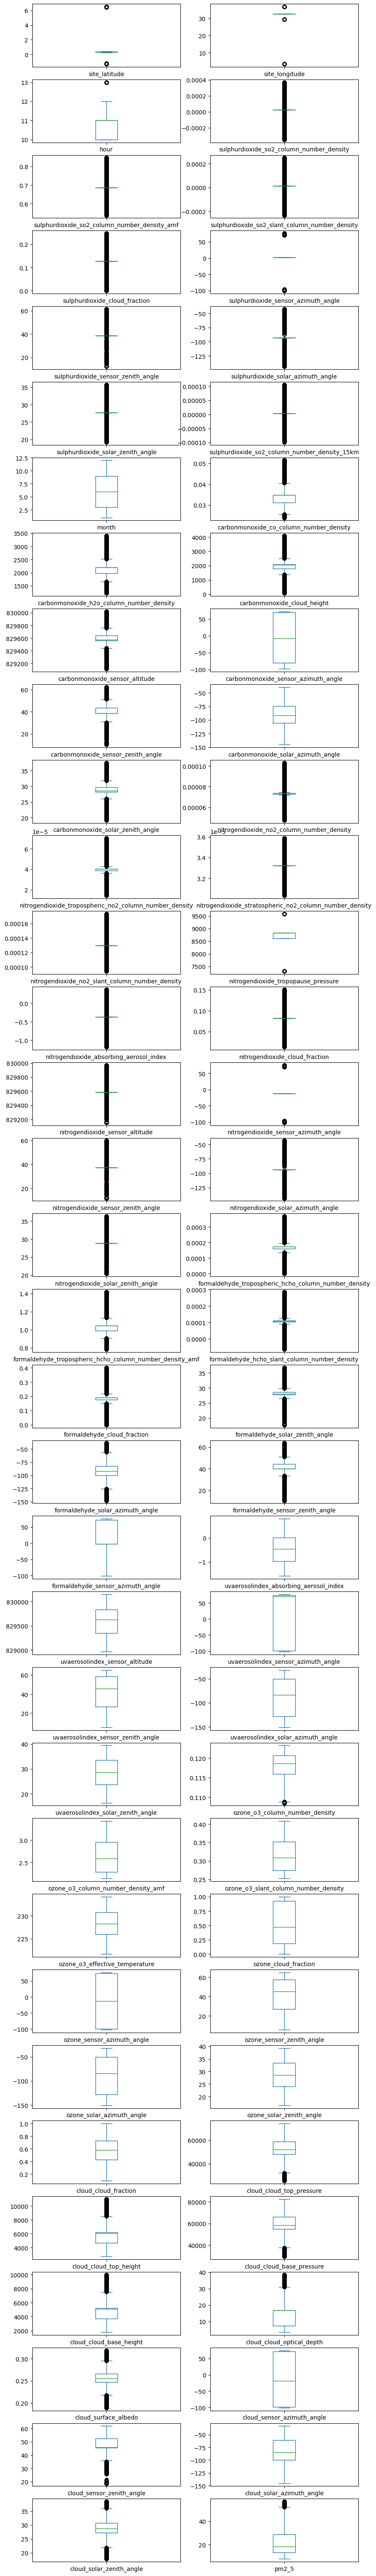

In [21]:
air.plot(kind='box', 
                   subplots=True, 
                   layout=(43, 2), 
                   sharex=False, 
                   figsize=(10, 100))

plt.show()

The boxplot above shown that there are still some outliers but removing them all will affect the data because some columns will have same unique value throughout.

# Exploratory Data Analysis (EDA)

In the exploratory data analysis, I will be looking at the distribution of the data, the coorelation between features and the target variable and the relationship between the features and the target variable.

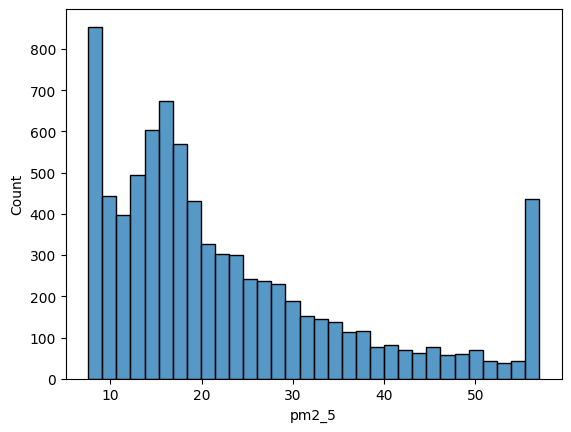

In [63]:
sns.histplot(air['pm2_5'])
plt.show()

#### City

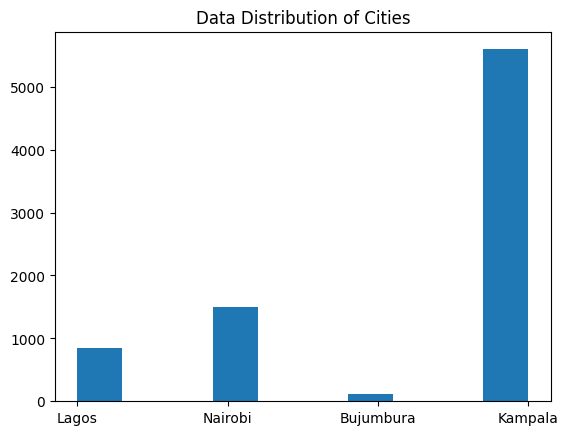

In [23]:
plt.hist('city', data=air)
plt.title('Data Distribution of Cities')
plt.show()

The plot above shown that Kampala has the highest number of entries recorded while Bujumbura has the lowest

#### Country

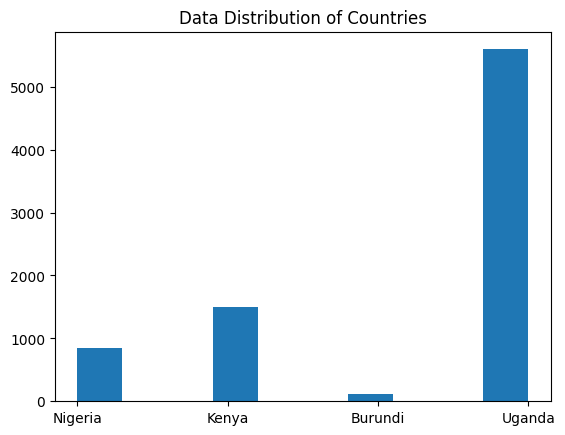

In [24]:
plt.hist('country', data=air)
plt.title('Data Distribution of Countries')
plt.show()

The plot shown before this had already ecplained the plot shown above.

#### Site

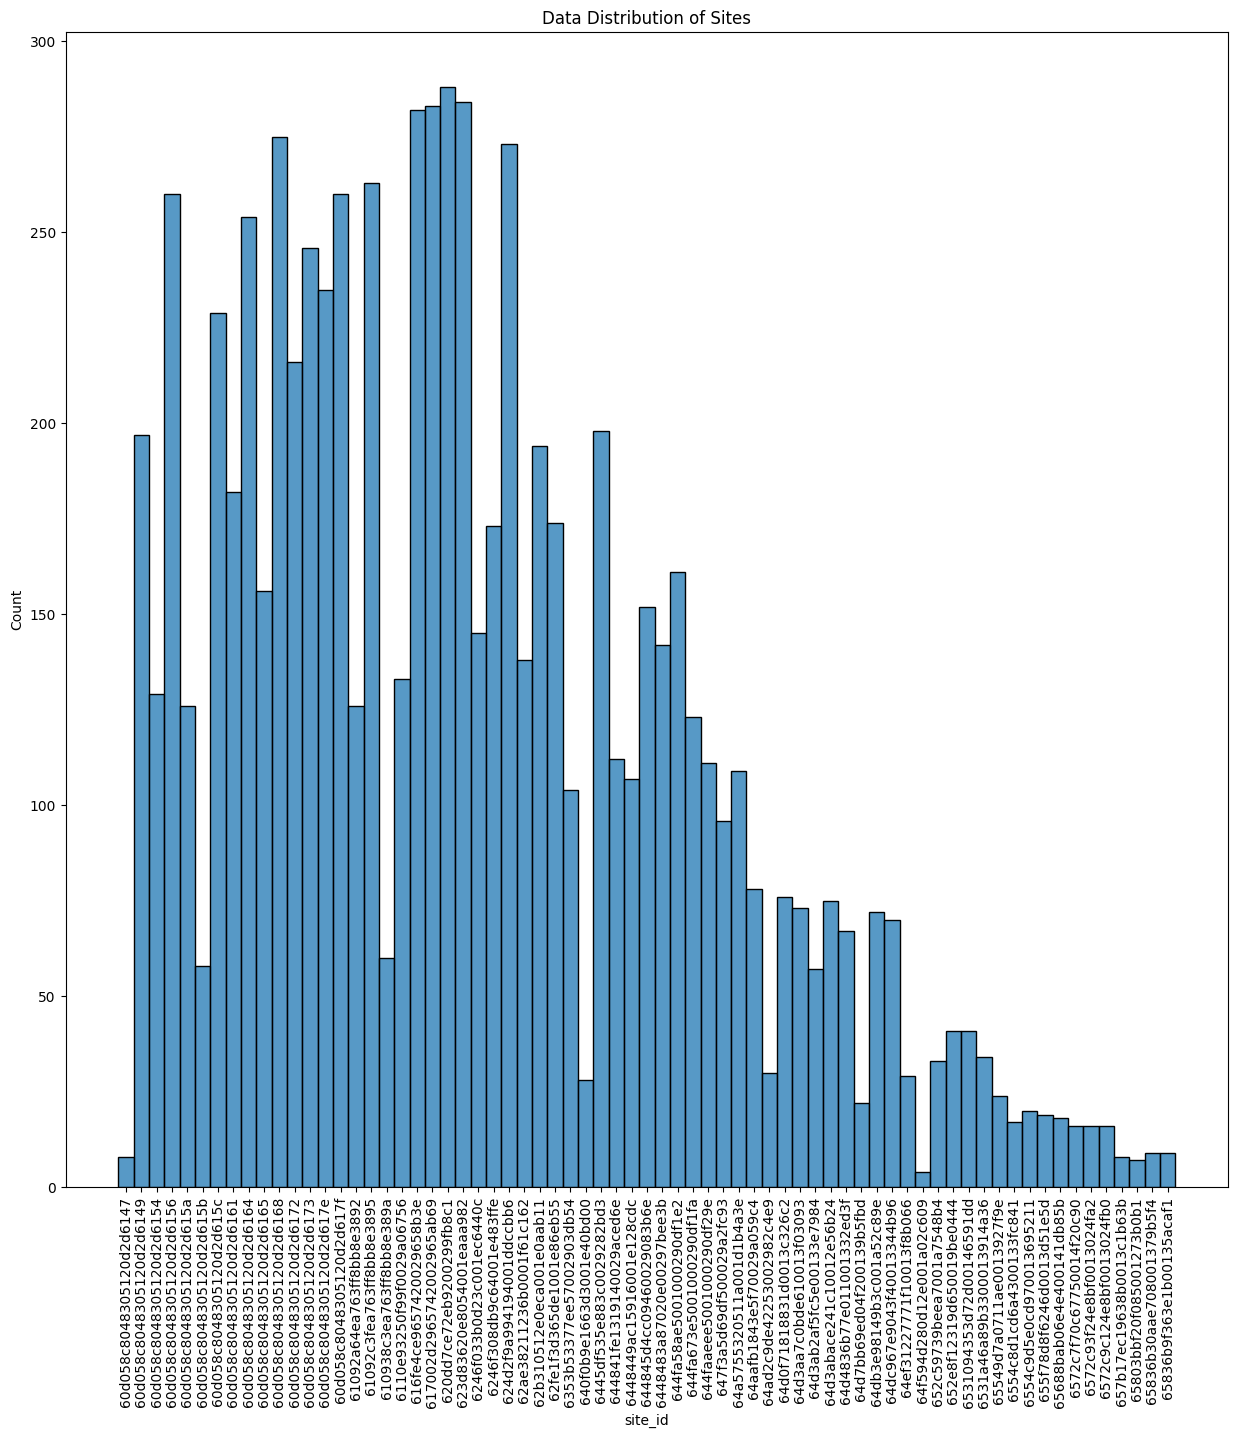

In [25]:
plt.figure(figsize=(15,15))
sns.histplot(air['site_id'])
plt.title('Data Distribution of Sites')
plt.xticks(rotation=90)
plt.show()

#### City and Target

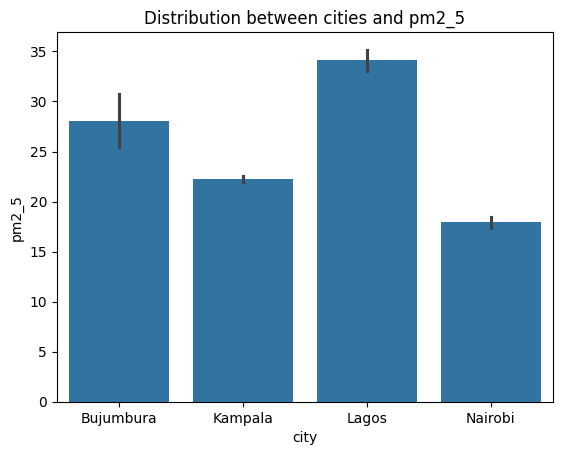

In [26]:
sns.barplot(x= air['city'], y=air['pm2_5'])
plt.title('Distribution between cities and pm2_5')
plt.show()

This plot shown that lagos has the maximum number of pm2_5

#### Site and Target

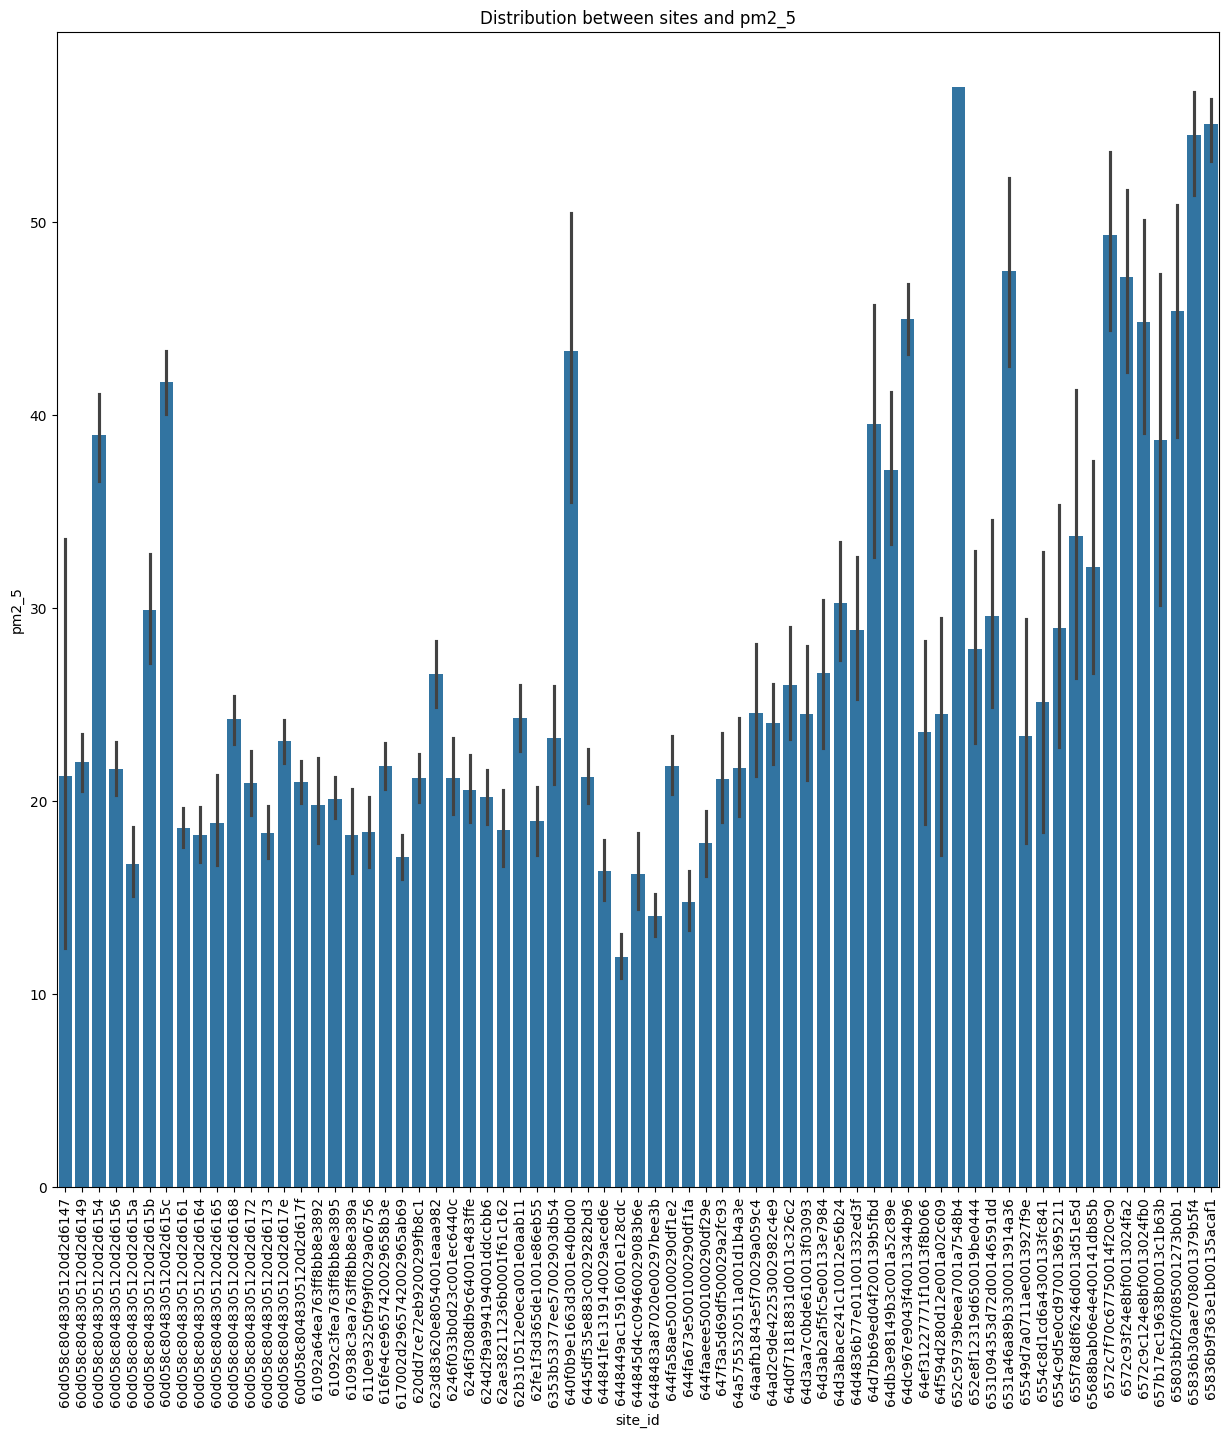

In [27]:
plt.figure(figsize=(15,15))
sns.barplot(x= air['site_id'], y=air['pm2_5'])
plt.title('Distribution between sites and pm2_5')
plt.xticks(rotation=90)
plt.show()

#### Site and City

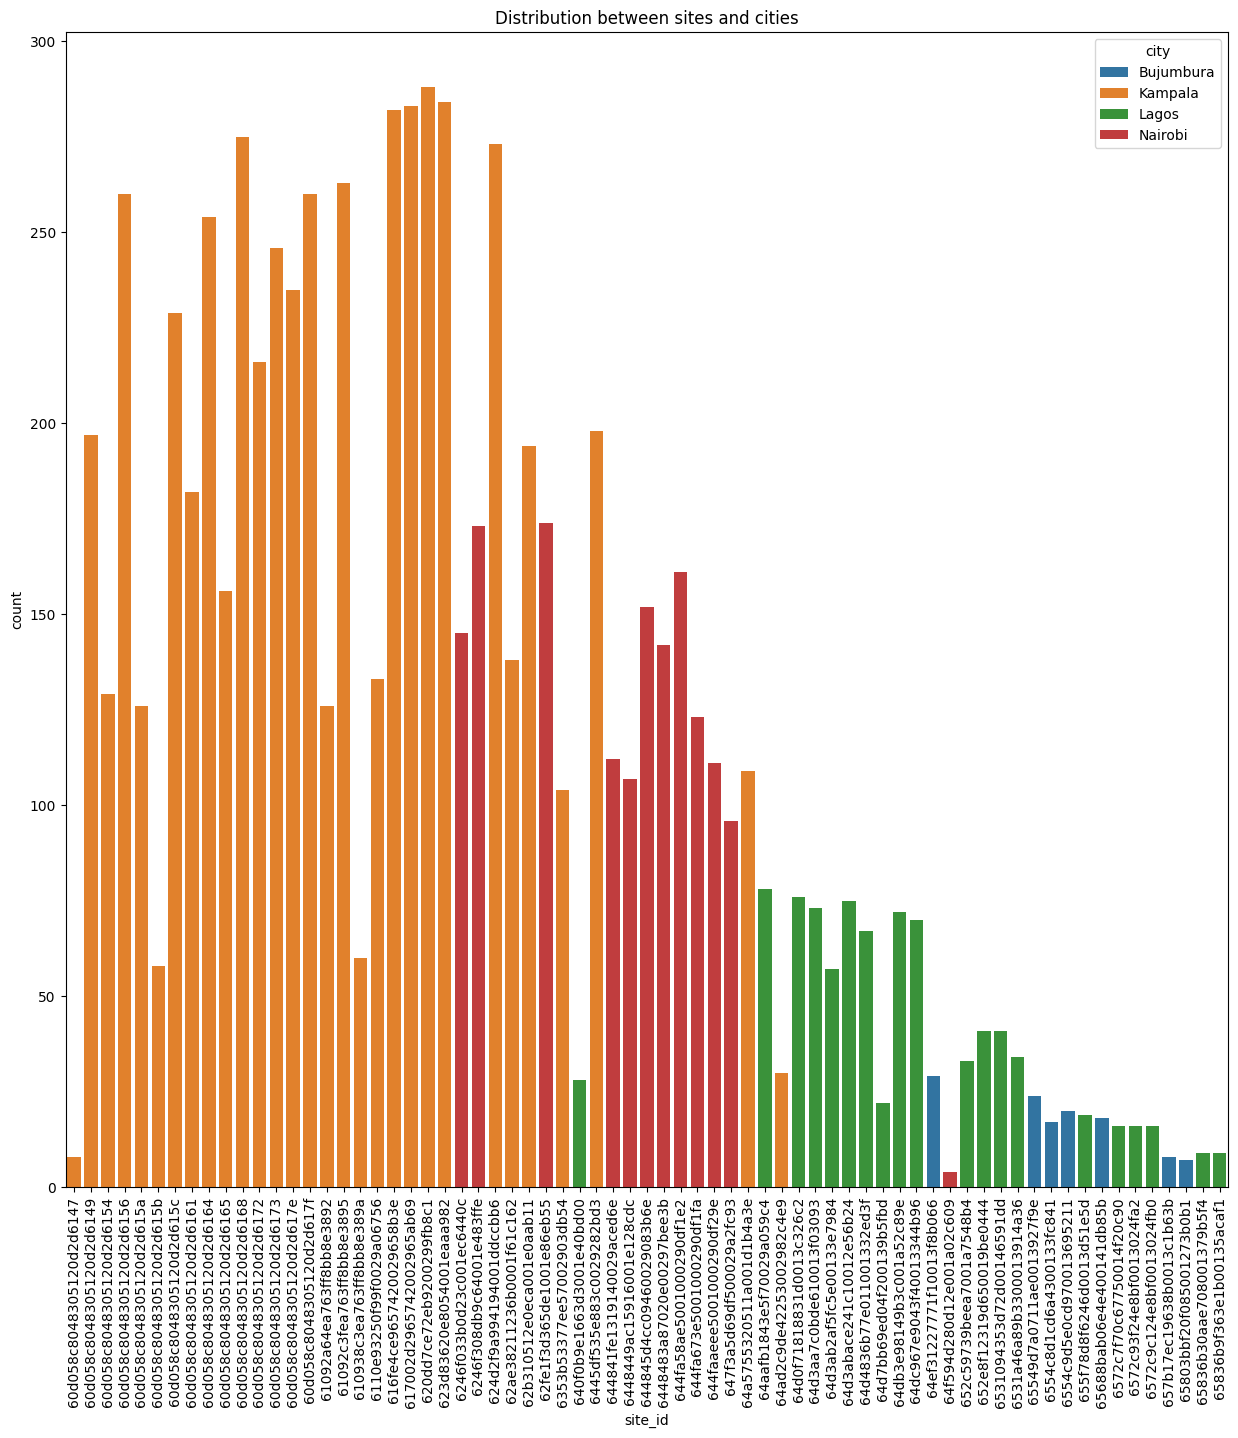

In [28]:
plt.figure(figsize=(15,15))
sns.countplot(x= air['site_id'], hue=air['city'], data=air)
plt.title('Distribution between sites and cities')
plt.xticks(rotation=90)
plt.show()

This chart shown that Kampala has the highest number of sites while Bujumbura has the least

# Feature Engineering

In this stage, I will be extracting new features from existing ones and I will drop irrelevant features.

In [29]:
# Extracting new features from date column

air['Year'] = air['date'].dt.year
air['Month'] = air['date'].dt.month
air['Day'] = air['date'].dt.day
air['DayOfWeek'] = air['date'].dt.dayofweek

In [30]:
air.head(5)

id                   site_id  site_latitude  site_longitude  \
0  id_vjcx08sz91  6531a46a89b3300013914a36        6.51767         3.39936   
1  id_bkg215syli  6531a46a89b3300013914a36        6.51767         3.39936   
2  id_oui2pot3qd  6531a46a89b3300013914a36        6.51767         3.39936   
3  id_9aandqzy4n  6531a46a89b3300013914a36        6.51767         3.39936   
4  id_ali5x2m4iw  6531a46a89b3300013914a36        6.51767         3.39936   

    city  country       date  hour  sulphurdioxide_so2_column_number_density  \
0  Lagos  Nigeria 2023-10-25  13.0                                  0.000024   
1  Lagos  Nigeria 2023-11-02  12.0                                  0.000024   
2  Lagos  Nigeria 2023-11-03  13.0                                  0.000024   
3  Lagos  Nigeria 2023-11-08  13.0                                  0.000024   
4  Lagos  Nigeria 2023-11-09  13.0                                  0.000267   

   sulphurdioxide_so2_column_number_density_amf  \
0                                      0.687295   
1                                      0.687295   
2                                      0.687295   
3                                      0.687295   
4                                      0.774656   

   sulphurdioxide_so2_slant_column_number_density  \
0                                        0.000013   
1                                        0.000013   
2                                        0.000013   
3                                        0.000013   
4                                        0.000207   

   sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
0                       0.126581                             2.120939   
1                       0.126581                             2.120939   
2                       0.126581                             2.120939   
3                       0.126581                             2.120939   
4                       0.223403                           -97.811241   

   sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
0                           38.671939                          -92.912582   
1                           38.671939                          -92.912582   
2                           38.671939                          -92.912582   
3                           38.671939                          -92.912582   
4                           49.513344                         -126.064468   

   sulphurdioxide_solar_zenith_angle  \
0                          27.700157   
1                          27.700157   
2                          27.700157   
3                          27.700157   
4                          35.742435   

   sulphurdioxide_so2_column_number_density_15km  month  \
0                                       0.000004   10.0   
1                                       0.000004   11.0   
2                                       0.000004   11.0   
3                                       0.000004   11.0   
4                                       0.000083   11.0   

   carbonmonoxide_co_column_number_density  \
0                                 0.034887   
1                                 0.045475   
2                                 0.034887   
3                                 0.034887   
4                                 0.049045   

   carbonmonoxide_h2o_column_number_density  carbonmonoxide_cloud_height  \
0                               2200.218221                  2041.463881   
1                               3397.928101                  3399.756845   
2                               2200.218221                  2041.463881   
3                               2200.218221                  2041.463881   
4                               3397.928101                  1678.370478   

   carbonmonoxide_sensor_altitude  carbonmonoxide_sensor_azimuth_angle  \
0                   829573.191993                            -8.063021   
1                   829113.625000                            69.

#### Dropping Irrelvant features

In [31]:
# Dropping  Irrelevant features

air = air.drop(columns=['id', 'date'], axis=1)

In [32]:
air.head(5)

site_id  site_latitude  site_longitude   city  country  \
0  6531a46a89b3300013914a36        6.51767         3.39936  Lagos  Nigeria   
1  6531a46a89b3300013914a36        6.51767         3.39936  Lagos  Nigeria   
2  6531a46a89b3300013914a36        6.51767         3.39936  Lagos  Nigeria   
3  6531a46a89b3300013914a36        6.51767         3.39936  Lagos  Nigeria   
4  6531a46a89b3300013914a36        6.51767         3.39936  Lagos  Nigeria   

   hour  sulphurdioxide_so2_column_number_density  \
0  13.0                                  0.000024   
1  12.0                                  0.000024   
2  13.0                                  0.000024   
3  13.0                                  0.000024   
4  13.0                                  0.000267   

   sulphurdioxide_so2_column_number_density_amf  \
0                                      0.687295   
1                                      0.687295   
2                                      0.687295   
3                                      0.687295   
4                                      0.774656   

   sulphurdioxide_so2_slant_column_number_density  \
0                                        0.000013   
1                                        0.000013   
2                                        0.000013   
3                                        0.000013   
4                                        0.000207   

   sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
0                       0.126581                             2.120939   
1                       0.126581                             2.120939   
2                       0.126581                             2.120939   
3                       0.126581                             2.120939   
4                       0.223403                           -97.811241   

   sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
0                           38.671939                          -92.912582   
1                           38.671939                          -92.912582   
2                           38.671939                          -92.912582   
3                           38.671939                          -92.912582   
4                           49.513344                         -126.064468   

   sulphurdioxide_solar_zenith_angle  \
0                          27.700157   
1                          27.700157   
2                          27.700157   
3                          27.700157   
4                          35.742435   

   sulphurdioxide_so2_column_number_density_15km  month  \
0                                       0.000004   10.0   
1                                       0.000004   11.0   
2                                       0.000004   11.0   
3                                       0.000004   11.0   
4                                       0.000083   11.0   

   carbonmonoxide_co_column_number_density  \
0                                 0.034887   
1                                 0.045475   
2                                 0.034887   
3                                 0.034887   
4                                 0.049045   

   carbonmonoxide_h2o_column_number_density  carbonmonoxide_cloud_height  \
0                               2200.218221                  2041.463881   
1                               3397.928101                  3399.756845   
2                               2200.218221                  2041.463881   
3                               2200.218221                  2041.463881   
4                               3397.928101                  1678.370478   

   carbonmonoxide_sensor_altitude  carbonmonoxide_sensor_azimuth_angle  \
0                   829573.191993                            -8.063021   
1                   829113.625000                            69.245351   
2                   829573.191993                            -8.063021   
3                   829573.191993                            -8.063021   
4   

# Data Preprocessing

At this stage of the project, I will be encoding the categorical data, i will normalize and standardize the data to have common scale.


#### Encoding the Categorical data

In [33]:
label_encoder = LabelEncoder()
for col in air.columns:
    if col in cat:
        air[col] = label_encoder.fit_transform(air[col])

In [34]:
air.head(5)

site_id  site_latitude  site_longitude  city  country  hour  \
0       56        6.51767         3.39936     2        2  13.0   
1       56        6.51767         3.39936     2        2  12.0   
2       56        6.51767         3.39936     2        2  13.0   
3       56        6.51767         3.39936     2        2  13.0   
4       56        6.51767         3.39936     2        2  13.0   

   sulphurdioxide_so2_column_number_density  \
0                                  0.000024   
1                                  0.000024   
2                                  0.000024   
3                                  0.000024   
4                                  0.000267   

   sulphurdioxide_so2_column_number_density_amf  \
0                                      0.687295   
1                                      0.687295   
2                                      0.687295   
3                                      0.687295   
4                                      0.774656   

   sulphurdioxide_so2_slant_column_number_density  \
0                                        0.000013   
1                                        0.000013   
2                                        0.000013   
3                                        0.000013   
4                                        0.000207   

   sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
0                       0.126581                             2.120939   
1                       0.126581                             2.120939   
2                       0.126581                             2.120939   
3                       0.126581                             2.120939   
4                       0.223403                           -97.811241   

   sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
0                           38.671939                          -92.912582   
1                           38.671939                          -92.912582   
2                           38.671939                          -92.912582   
3                           38.671939                          -92.912582   
4                           49.513344                         -126.064468   

   sulphurdioxide_solar_zenith_angle  \
0                          27.700157   
1                          27.700157   
2                          27.700157   
3                          27.700157   
4                          35.742435   

   sulphurdioxide_so2_column_number_density_15km  month  \
0                                       0.000004   10.0   
1                                       0.000004   11.0   
2                                       0.000004   11.0   
3                                       0.000004   11.0   
4                                       0.000083   11.0   

   carbonmonoxide_co_column_number_density  \
0                                 0.034887   
1                                 0.045475   
2                                 0.034887   
3                                 0.034887   
4                                 0.049045   

   carbonmonoxide_h2o_column_number_density  carbonmonoxide_cloud_height  \
0                               2200.218221                  2041.463881   
1                               3397.928101                  3399.756845   
2                               2200.218221                  2041.463881   
3                               2200.218221                  2041.463881   
4                               3397.928101                  1678.370478   

   carbonmonoxide_sensor_altitude  carbonmonoxide_sensor_azimuth_angle  \
0                   829573.191993                            -8.063021   
1                   829113.625000                            69.245351   
2                   829573.191993                            -8.063021   
3                   829573.191993                            -8.063021   
4                   829113.625000                           -96.099639   

   carbonmonoxide_se

#### Splitting data to feature and target

In [35]:
#seperating feeature and target data
X = air.drop('pm2_5', axis=1)
y = air['pm2_5']

In [36]:
X.head(5)

site_id  site_latitude  site_longitude  city  country  hour  \
0       56        6.51767         3.39936     2        2  13.0   
1       56        6.51767         3.39936     2        2  12.0   
2       56        6.51767         3.39936     2        2  13.0   
3       56        6.51767         3.39936     2        2  13.0   
4       56        6.51767         3.39936     2        2  13.0   

   sulphurdioxide_so2_column_number_density  \
0                                  0.000024   
1                                  0.000024   
2                                  0.000024   
3                                  0.000024   
4                                  0.000267   

   sulphurdioxide_so2_column_number_density_amf  \
0                                      0.687295   
1                                      0.687295   
2                                      0.687295   
3                                      0.687295   
4                                      0.774656   

   sulphurdioxide_so2_slant_column_number_density  \
0                                        0.000013   
1                                        0.000013   
2                                        0.000013   
3                                        0.000013   
4                                        0.000207   

   sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
0                       0.126581                             2.120939   
1                       0.126581                             2.120939   
2                       0.126581                             2.120939   
3                       0.126581                             2.120939   
4                       0.223403                           -97.811241   

   sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
0                           38.671939                          -92.912582   
1                           38.671939                          -92.912582   
2                           38.671939                          -92.912582   
3                           38.671939                          -92.912582   
4                           49.513344                         -126.064468   

   sulphurdioxide_solar_zenith_angle  \
0                          27.700157   
1                          27.700157   
2                          27.700157   
3                          27.700157   
4                          35.742435   

   sulphurdioxide_so2_column_number_density_15km  month  \
0                                       0.000004   10.0   
1                                       0.000004   11.0   
2                                       0.000004   11.0   
3                                       0.000004   11.0   
4                                       0.000083   11.0   

   carbonmonoxide_co_column_number_density  \
0                                 0.034887   
1                                 0.045475   
2                                 0.034887   
3                                 0.034887   
4                                 0.049045   

   carbonmonoxide_h2o_column_number_density  carbonmonoxide_cloud_height  \
0                               2200.218221                  2041.463881   
1                               3397.928101                  3399.756845   
2                               2200.218221                  2041.463881   
3                               2200.218221                  2041.463881   
4                               3397.928101                  1678.370478   

   carbonmonoxide_sensor_altitude  carbonmonoxide_sensor_azimuth_angle  \
0                   829573.191993                            -8.063021   
1                   829113.625000                            69.245351   
2                   829573.191993                            -8.063021   
3                   829573.191993                            -8.063021   
4                   829113.625000                           -96.099639   

   carbonmonoxide_se

In [37]:
y.head()

0    12.015000
1    42.267200
2    39.450741
3    10.537600
4    19.431731
Name: pm2_5, dtype: float64

#### Data Scaling

I will be using MinMaxScaler to scale the data so that the minimum scale will be 0 and the maximum scale will be 1

In [38]:
minmax = MinMaxScaler(feature_range=(0, 1)) # Instantiating

rescaled_X = minmax.fit_transform(X) # fitting and transforming

In [39]:
rescaled_X

array([[8.23529412e-01, 1.00000000e+00, 8.45730949e-04, ...,
        8.18181818e-01, 8.00000000e-01, 3.33333333e-01],
       [8.23529412e-01, 1.00000000e+00, 8.45730949e-04, ...,
        9.09090909e-01, 3.33333333e-02, 5.00000000e-01],
       [8.23529412e-01, 1.00000000e+00, 8.45730949e-04, ...,
        9.09090909e-01, 6.66666667e-02, 6.66666667e-01],
       ...,
       [5.73529412e-01, 4.90799177e-03, 9.98724263e-01, ...,
        0.00000000e+00, 8.00000000e-01, 5.00000000e-01],
       [5.73529412e-01, 4.90799177e-03, 9.98724263e-01, ...,
        0.00000000e+00, 8.33333333e-01, 6.66666667e-01],
       [5.73529412e-01, 4.90799177e-03, 9.98724263e-01, ...,
        0.00000000e+00, 8.66666667e-01, 8.33333333e-01]])

In [40]:
rescaled_X.shape

(8071, 74)

In [41]:
X.columns

Index(['site_id', 'site_latitude', 'site_longitude', 'city', 'country', 'hour',
       'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'n

In [42]:
rescaled_X_df = pd.DataFrame(rescaled_X, columns=X.columns)

rescaled_X_df.head(10)

site_id  site_latitude  site_longitude      city   country      hour  \
0  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
1  0.823529            1.0        0.000846  0.666667  0.666667  0.666667   
2  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
3  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
4  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
5  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
6  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
7  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
8  0.823529            1.0        0.000846  0.666667  0.666667  1.000000   
9  0.823529            1.0        0.000846  0.666667  0.666667  0.666667   

   sulphurdioxide_so2_column_number_density  \
0                                  0.517392   
1                                  0.517392   
2                                  0.517392   
3                                  0.517392   
4                                  0.855909   
5                                  0.302431   
6                                  0.509647   
7                                  0.517392   
8                                  0.710600   
9                                  0.642472   

   sulphurdioxide_so2_column_number_density_amf  \
0                                      0.483536   
1                                      0.483536   
2                                      0.483536   
3                                      0.483536   
4                                      0.767912   
5                                      0.470378   
6                                      1.000000   
7                                      0.483536   
8                                      0.000000   
9                                      0.186002   

   sulphurdioxide_so2_slant_column_number_density  \
0                                        0.507493   
1                                        0.507493   
2                                        0.507493   
3                                        0.507493   
4                                        0.912361   
5                                        0.295913   
6                                        0.512324   
7                                        0.507493   
8                                        0.593974   
9                                        0.622664   

   sulphurdioxide_cloud_fraction  sulphurdioxide_sensor_azimuth_angle  \
0                       0.512938                             0.583198   
1                       0.512938                             0.583198   
2                       0.512938                             0.583198   
3                       0.512938                             0.583198   
4                       0.905286                             0.016153   
5                       0.585268                             0.000000   
6                       0.929740                             1.000000   
7                       0.512938                             0.583198   
8                       0.463067                             1.000000   
9                       0.305714                             0.988328   

   sulphurdioxide_sensor_zenith_angle  sulphurdioxide_solar_azimuth_angle  \
0                            0.537283                            0.500572   
1                            0.537283                            0.500572   
2                            0.537283                            0.500572   
3                            0.537283                            0.500572   
4                            0.757617                            0.173405   
5                            0.192780                            0.128446   
6                            0.099821                            0.073853   
7                            0.537283                            0.500572   
8     

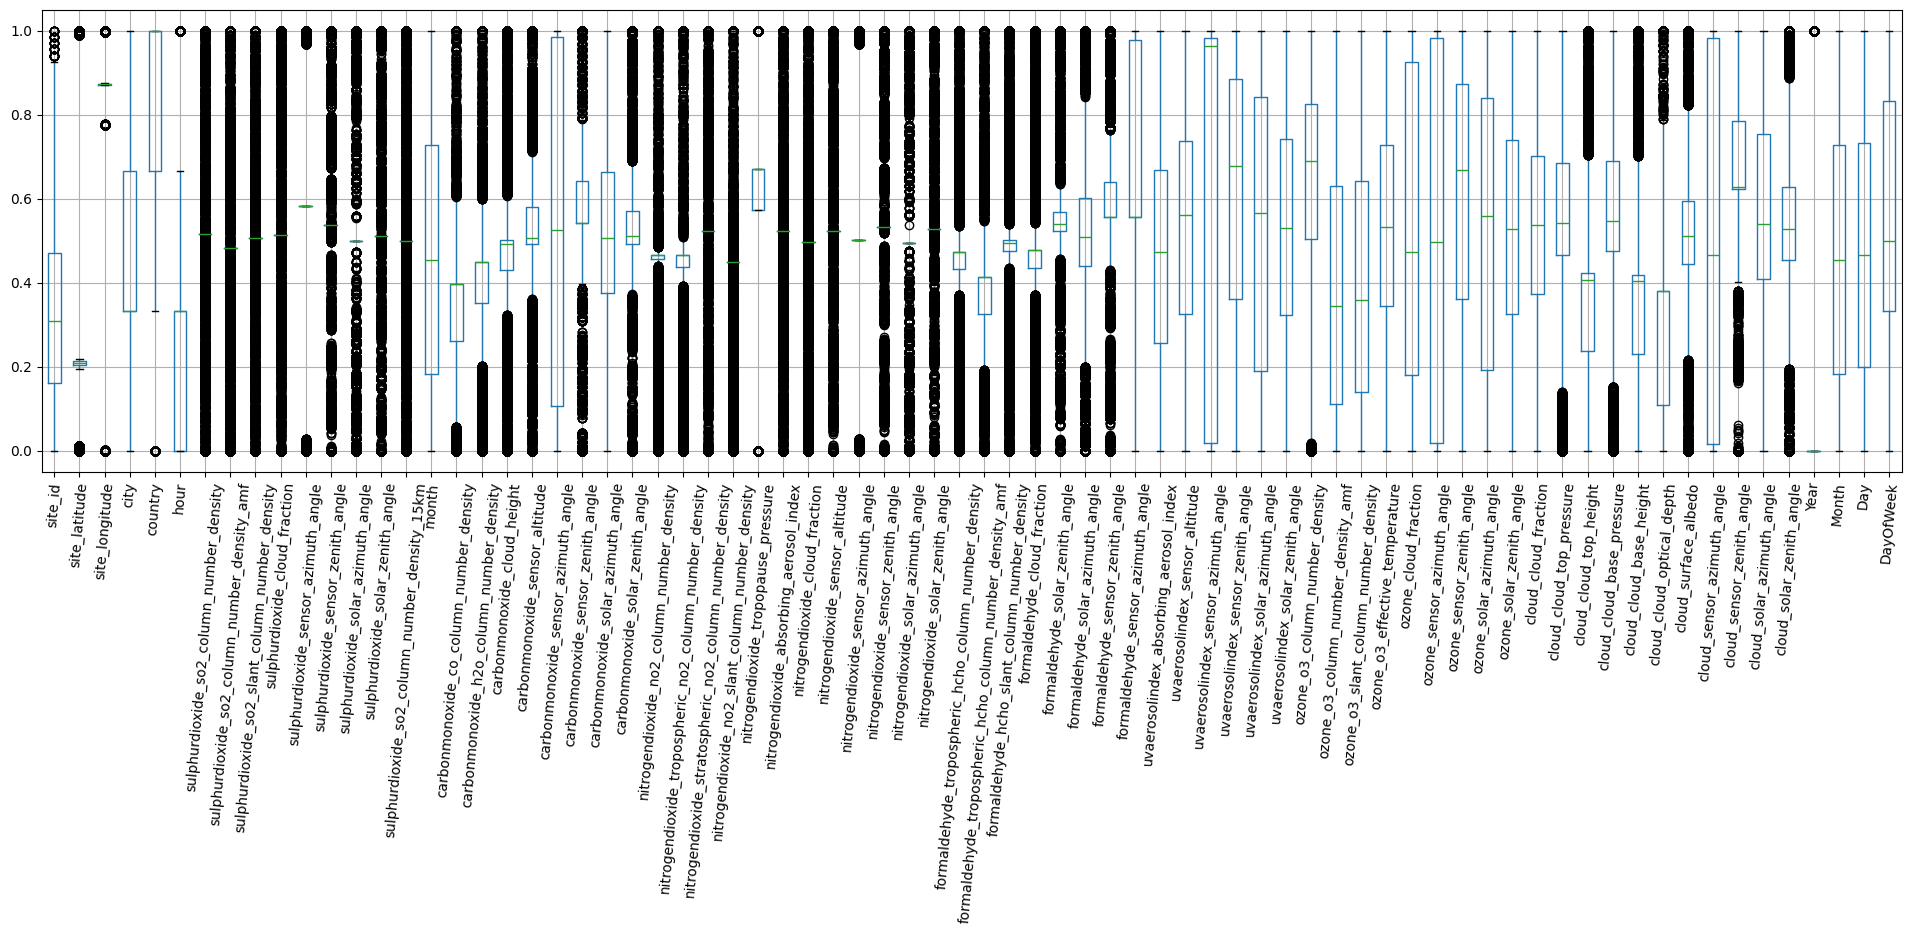

In [43]:
rescaled_X_df.boxplot(figsize=(24,6), rot= 85);

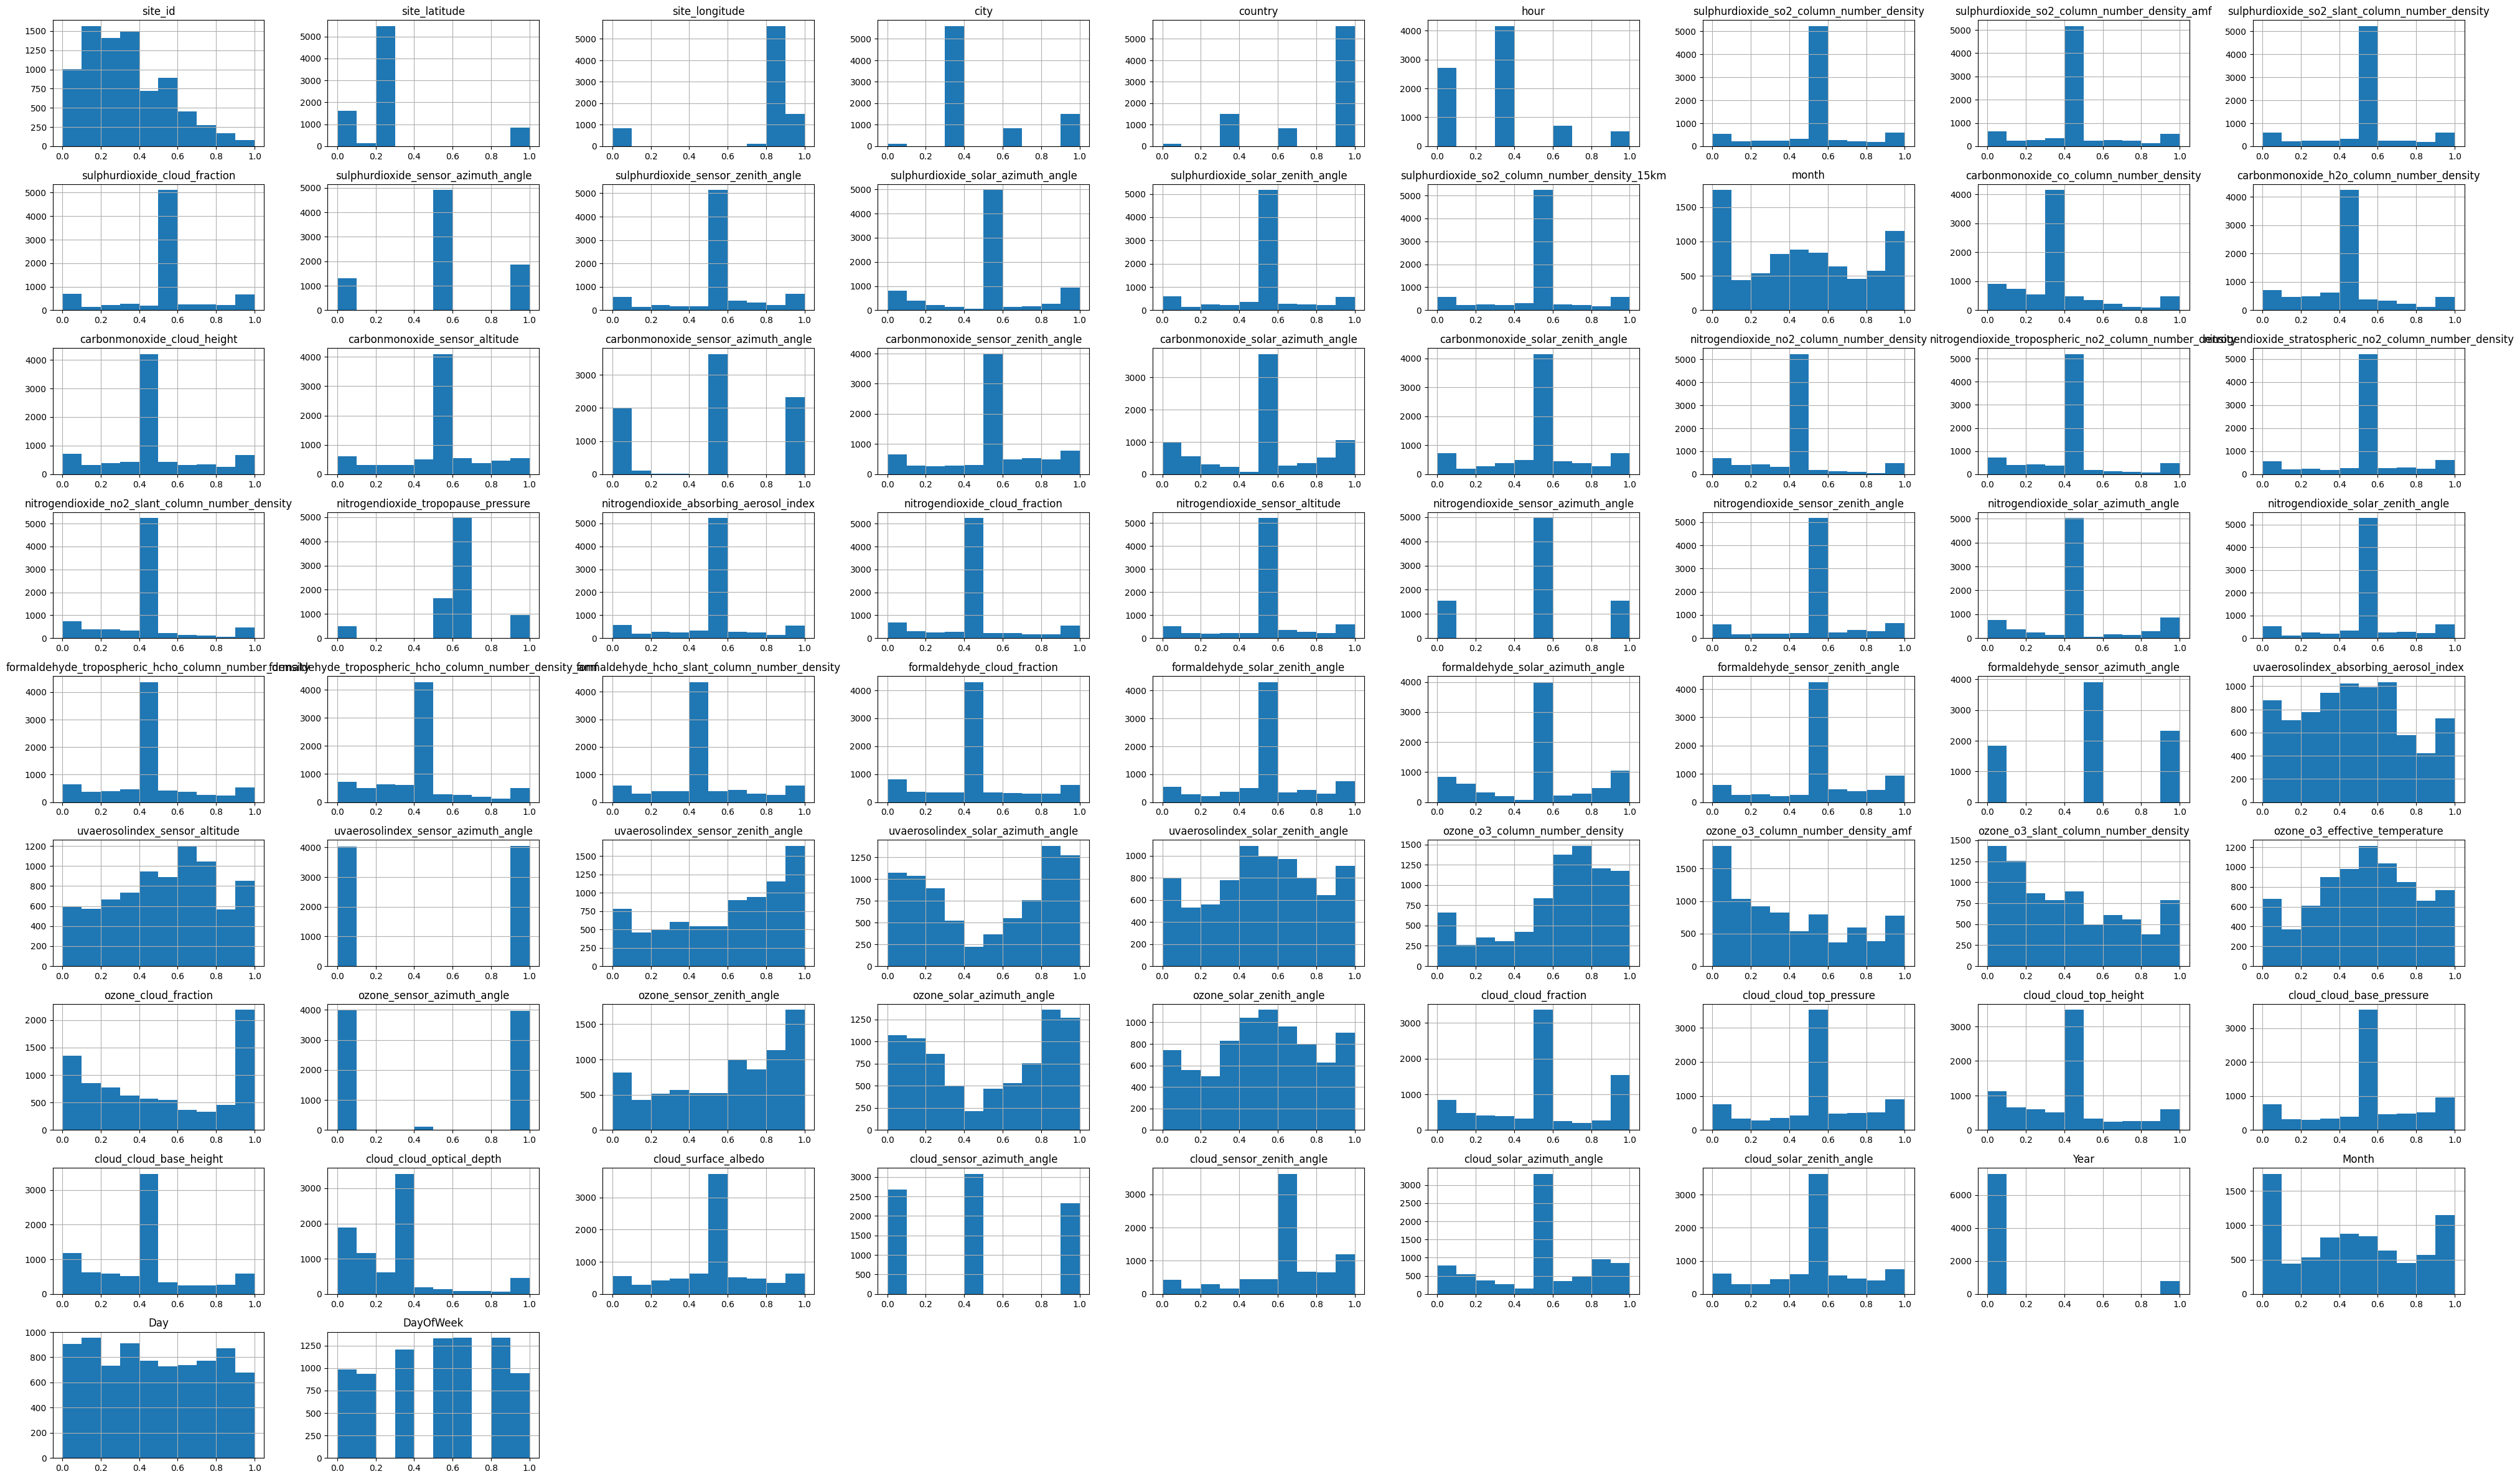

In [44]:
rescaled_X_df.hist(figsize=(50,30))
plt.show()

### Coorelation Matrix Heatmap

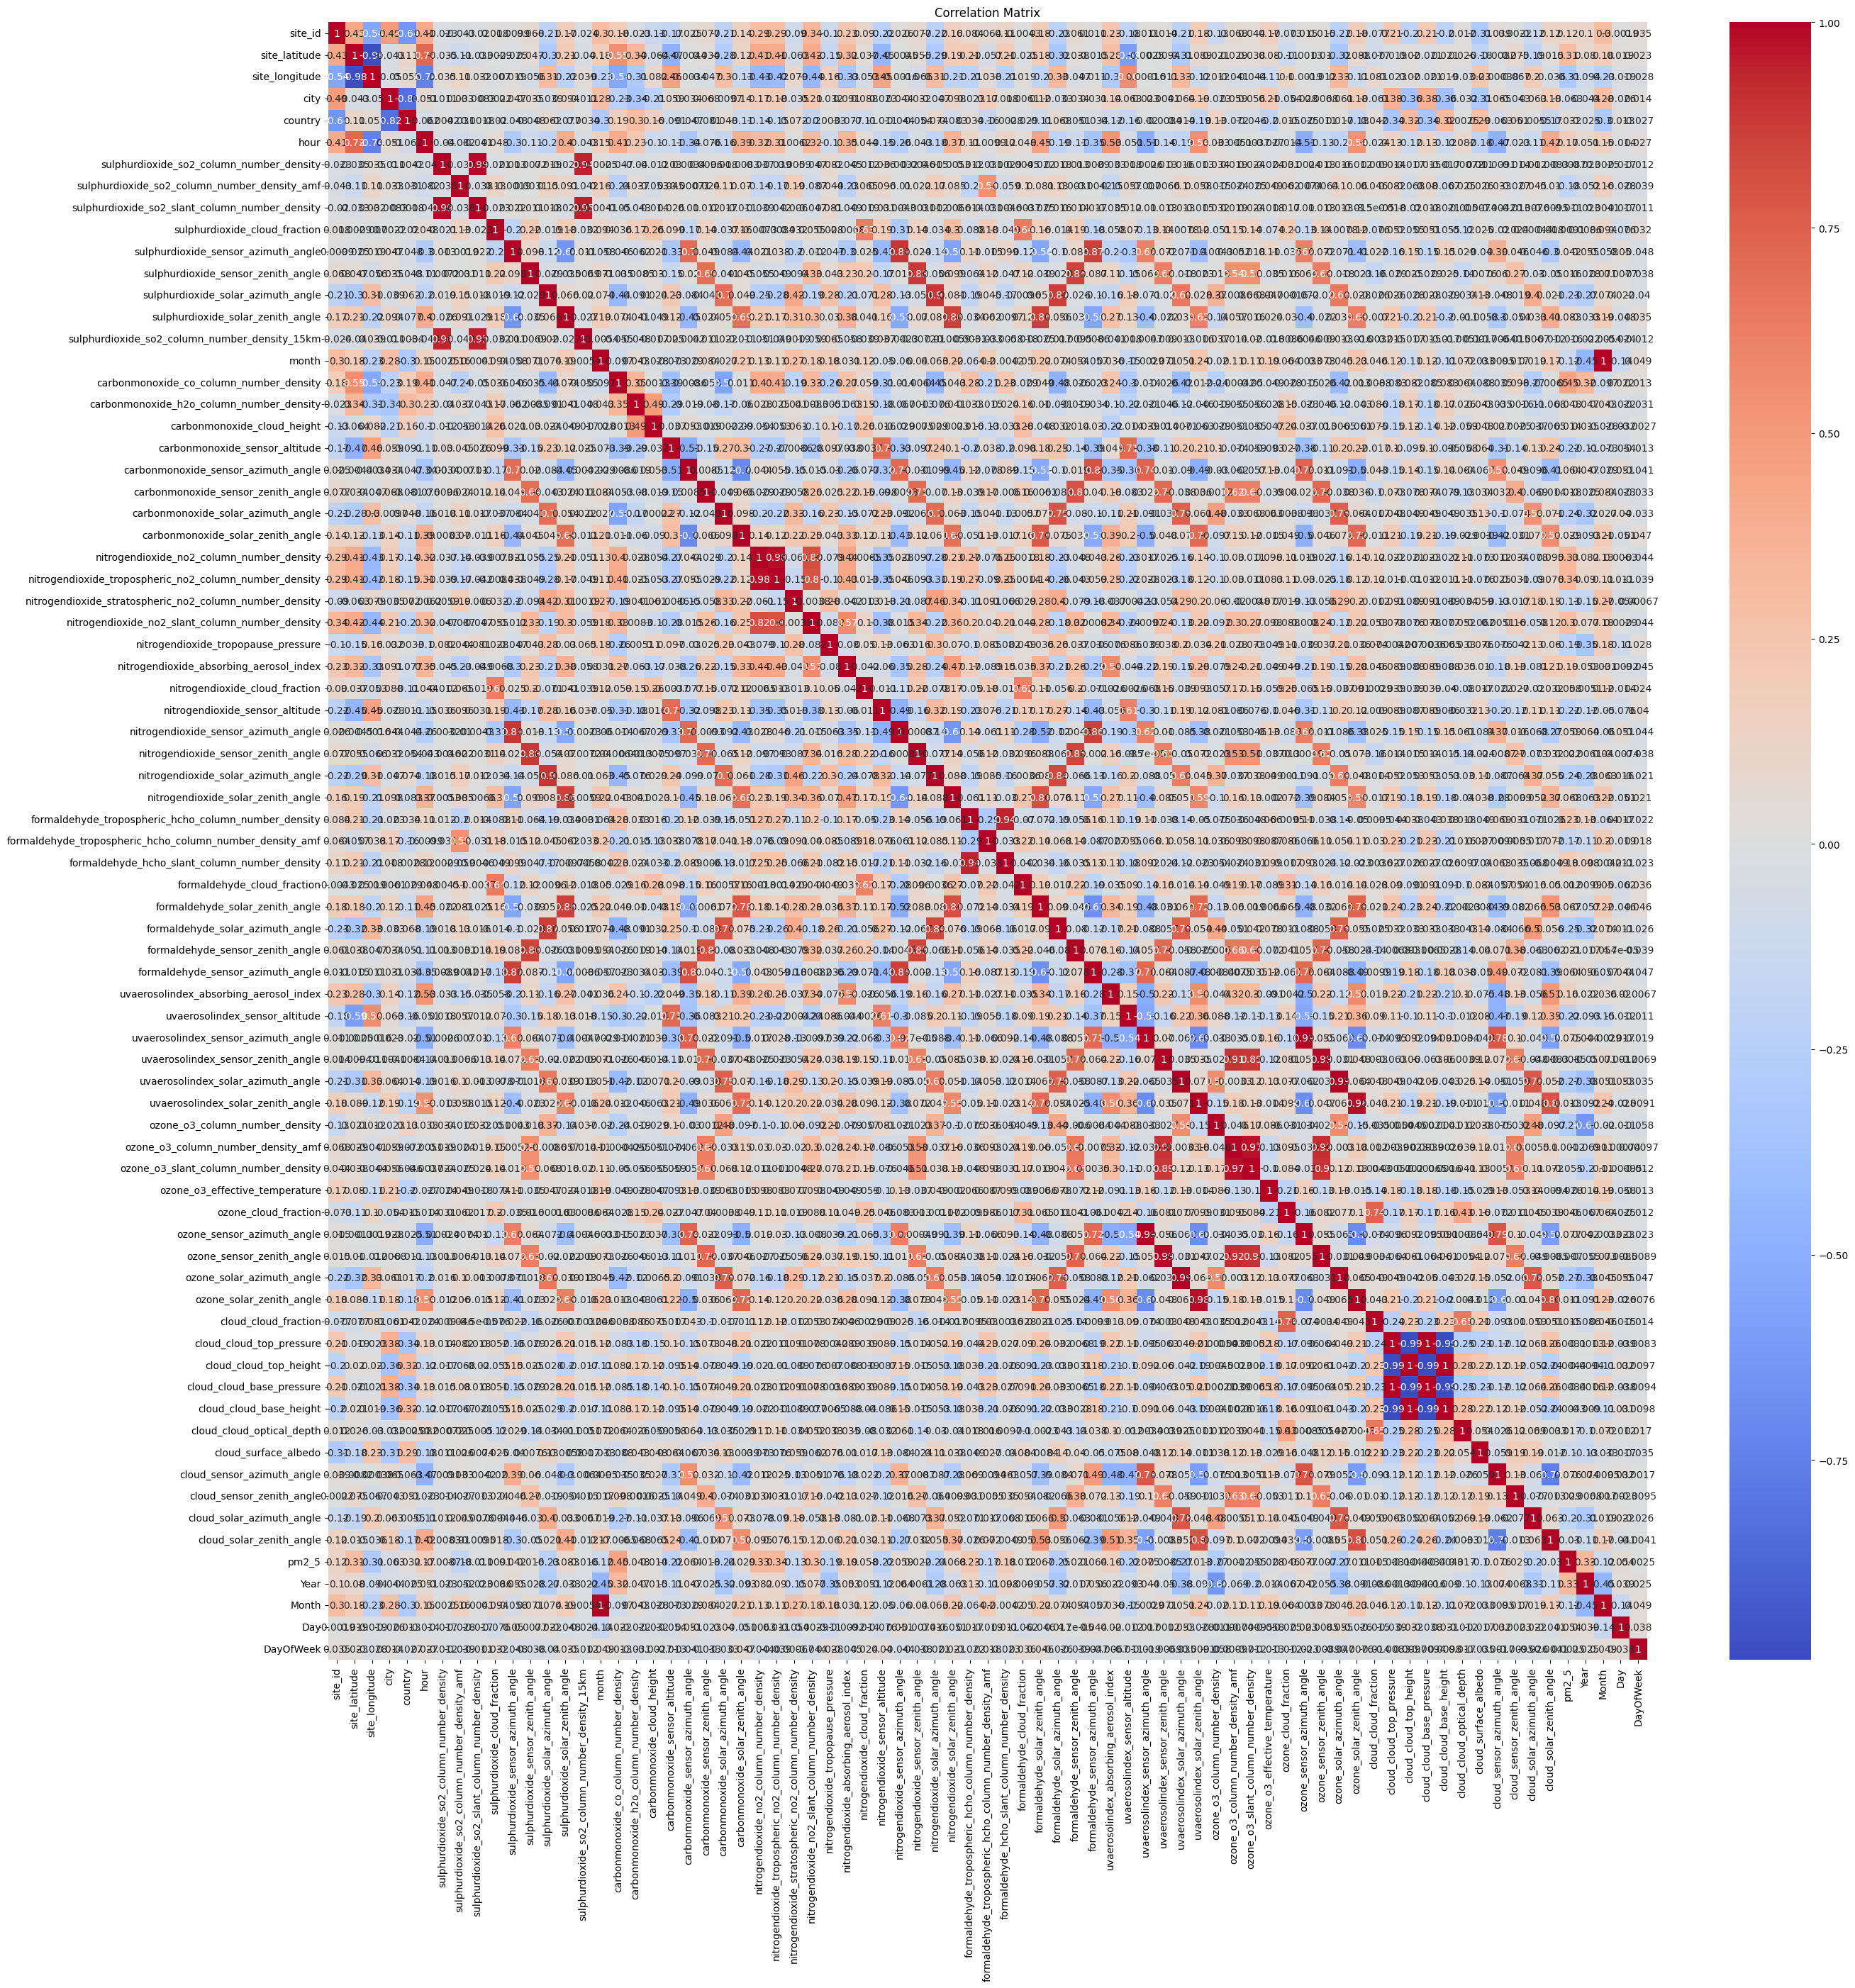

In [45]:
plt.figure(figsize=(30,30))
sns.heatmap(air.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Train Test Splitting

In [46]:
X_train, X_test, y_train, y_test = train_test_split(rescaled_X_df, y)

# Machine Learning

### DecisionTreeRegressor

In [47]:
# Initializing the Regressor
dtr = DecisionTreeRegressor(random_state=42)

# Training the model

dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [48]:
# Making Predictions 
dtr_y_pred = dtr.predict(X_test)

In [49]:
print('MAE: ', mean_absolute_error(y_test, dtr_y_pred))

print('MSE: ', mean_squared_error(y_test, dtr_y_pred))

dtr_rmse = root_mean_squared_error(y_test, dtr_y_pred)
print('RMSE: ', dtr_rmse)

MAE:  6.424462148716276
MSE:  96.98151915888373
RMSE:  9.847919534545545


### Random Forest Regressor

In [50]:
# Initializing the Regressor
rf = RandomForestRegressor()

# Training the model
rf.fit(X_train, y_train)

RandomForestRegressor()

In [51]:
# making predictions
rf_pred = rf.predict(X_test)

In [52]:
print('MAE: ', mean_absolute_error(y_test, rf_pred))

print('MSE: ', mean_squared_error(y_test, rf_pred))

rf_rmse = root_mean_squared_error(y_test, rf_pred)
print('RMSE: ', rf_rmse)

MAE:  4.940586309153186
MSE:  50.76307478900215
RMSE:  7.124821035577114


### Ridge

In [53]:
# Initializing the model
rd = Ridge()

rd.fit(X_train, y_train)

Ridge()

In [54]:
rd_pred = rd.predict(X_test)

In [55]:
print('MAE: ', mean_absolute_error(y_test, rd_pred))

print('MSE: ', mean_squared_error(y_test, rd_pred))

rd_rmse = root_mean_squared_error(y_test, rd_pred)
print('RMSE: ', rd_rmse)

MAE:  8.498417044924267
MSE:  125.2937941836265
RMSE:  11.193471051627663


### XGBoost

In [56]:
# converting data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [57]:
# parameters for xgb
parameters = {
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse'
}

In [58]:
# training the model
model_xgb = xgb.train(parameters, dtrain)

In [59]:
# Making Prediction
xgb_pred = model_xgb.predict(dtest)

In [60]:
print('MAE: ', mean_absolute_error(y_test, xgb_pred))

print('MSE: ', mean_squared_error(y_test, xgb_pred))

xgb_rmse = root_mean_squared_error(y_test, xgb_pred)
print('RMSE: ', xgb_rmse)

MAE:  5.920387177653396
MSE:  66.1584684562378
RMSE:  8.133785616564884


# Comparative Analysis

In [61]:
# Creating a Dictionary
metrics_dict = {
    'model': [],
    'MAE' : [],
    'MSE' : [],
    'RMSE' : [],
}

metrics_dict['model'].append('Decision Tree Regressor')
metrics_dict['MAE'].append(mean_absolute_error(y_test, dtr_y_pred))
metrics_dict['MSE'].append(mean_squared_error(y_test, dtr_y_pred))
metrics_dict['RMSE'].append(root_mean_squared_error(y_test, dtr_y_pred))

metrics_dict['model'].append('Random Forest Regressor')
metrics_dict['MAE'].append(mean_absolute_error(y_test, rf_pred))
metrics_dict['MSE'].append(mean_squared_error(y_test, rf_pred))
metrics_dict['RMSE'].append(root_mean_squared_error(y_test, rf_pred))

metrics_dict['model'].append('Ridge')
metrics_dict['MAE'].append(mean_absolute_error(y_test, rd_pred))
metrics_dict['MSE'].append(mean_squared_error(y_test, rd_pred))
metrics_dict['RMSE'].append(root_mean_squared_error(y_test, rd_pred))

metrics_dict['model'].append('XGBoost')
metrics_dict['MAE'].append(mean_absolute_error(y_test, xgb_pred))
metrics_dict['MSE'].append(mean_squared_error(y_test, xgb_pred))
metrics_dict['RMSE'].append(root_mean_squared_error(y_test, xgb_pred))

In [62]:
# converting all metrics into a dataframe
df_metrics = pd.DataFrame(metrics_dict)

print(df_metrics)

                     model       MAE         MSE       RMSE
0  Decision Tree Regressor  6.424462   96.981519   9.847920
1  Random Forest Regressor  4.940586   50.763075   7.124821
2                    Ridge  8.498417  125.293794  11.193471
3                  XGBoost  5.920387   66.158468   8.133786


### Models Strengths and Weaknesses

 **Random Forest Regressor**
   - **Strengths:**
     - Achieves the lowest RMSE among the models listed, indicating superior predictive accuracy in your context.
     - Reduces overfitting compared to a single decision tree by averaging multiple trees.

   - **Weaknesses:**
     - Can be computationally expensive due to training multiple trees.

**XGBoost**
   - **Strengths:**
     - Offers competitive performance with a low RMSE, similar to Random Forest.
     - Handles missing data and captures complex relationships well.
     - Provides feature importance which aids in feature selection.

   - **Weaknesses:**
     - Requires careful tuning of hyperparameters.
     - More complex and less interpretable compared to simpler models.

**Decision Tree Regressor**
   - **Strengths:**
     - Interpretable and easy to understand.
     - Captures complex relationships in data.

   - **Weaknesses:**
     - Likely higher RMSE compared to Random Forest and XGBoost, indicating potentially inferior predictive accuracy.
     - Prone to overfitting and sensitive to noisy data.

**Ridge Regression**
   - **Strengths:**
     - Provides a stable and robust solution.
     - Handles multicollinearity well.

   - **Weaknesses:**
     - Highest RMSE among the models listed, suggesting lower predictive accuracy in this context.
     - Assumes a linear relationship between predictors and the target variable.

## Conclusion
The Random Forest Regression model has demonstrated superior predictive performance compared to other models evaluated, as indicated by its lowest RMSE value among the options considered. Random Forest is known for its robustness against overfitting, thanks to the ensemble of decision trees and the averaging of results, which helps in improving generalization to new data.
It provides insights into feature importance, aiding in feature selection and interpretation of the model's predictive behavior.
